<!--NOTEBOOK_HEADER-->
*This notebook contains material from [CBE60499](https://ndcbe.github.io/CBE60499);
content is available [on Github](git@github.com:ndcbe/CBE60499.git).*


<!--NAVIGATION-->
< [2.9 Pyomo Homework 2](https://ndcbe.github.io/CBE60499/02.09-Pyomo2.html) | [Contents](toc.html) | [3.0 Unconstrained Nonlinear Optimization: Theory and Algorithms](https://ndcbe.github.io/CBE60499/03.00-Unconstrained.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/02.10-Pyomo3.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/02.10-Pyomo3.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>

# 2.10 Pyomo Homework 3

In [1]:
# Import the libraries you need here for the assignment
import sys
if "google.colab" in sys.modules:
    !wget "https://raw.githubusercontent.com/ndcbe/CBE60499/main/notebooks/helper.py"
    import helper
    !pip install casadi
    helper.install_idaes()
    #helper.install_ipopt()
from pyomo.environ import *
from pyomo.dae import *
from pyomo.dae.simulator import Simulator
import matplotlib.pyplot as plt
import numpy as np

## 2.10.1 Pyomo.DAE: Reaction Kinetics

Consider the chemical reaction $$A \Leftrightarrow B \Leftrightarrow C$$

which is modeling with the following differential algebraic equations:

$$\begin{align*}
\frac{dz_A}{dt} &= -p_1 z_A(t) + p_2 z_B(t),\quad z_A(0)=1 \\
\frac{dz_B}{dt} &= p_1 z_A(t) - (p_2 + p_3) z_B(t) + p_4 z_C(t), \quad z_B(0)=0 \\
1 &= z_A(t) + z_B(t) + z_C(t)
\end{align*}$$

where $p_1=4$, $p_2=2$, $p_3=40$, and $p_4=20$ are parameters with the appropriate units. $z_A(t)$, $z_B(t)$, and $z_C(t)$ are time varying concentrations of species $A$, $B$, and $C$ respectively.

### 2.10.1.1 Index analysis

Determine the index of the above differential algebraic equation (DAE) system above.

Tip: do this on paper. On Gradescope, there will be a separate assignment for you to turn in your handwritten work.

### 2.10.1.2 Model reformulation

Apply the index reduction algorithm from class as needed. Ultimately identify two versions of the model: one that is index 1 and another that is index 0. Find a consistent initial condition $z_C(0)$.

### 2.10.1.3 Implement index 1 model in Pyomo

We will be building a library of functions.

#### 2.10.1.3.1 Create model and set initial conditions

In [2]:
def create_model():
    ''' Create index 1 model and set initial conditions
    
    Return:
        m: Pyomo model
    '''
    
    # Tip: Set time to go from 0 to 1 when creating the model.
    
    # Begin Solution
    
    # Declare model
    m = ConcreteModel()
    
    # Declare time
    m.t = ContinuousSet(bounds=(0.0, 1.0))
    
    # Declare parameters
    m.p1 = Param(initialize=4.0)
    m.p2 = Param(initialize=2.0)
    m.p3 = Param(initialize=40.0)
    m.p4 = Param(initialize=20.0)
    
    # Declare variables indexed over time
    m.zA = Var(m.t)
    m.zB = Var(m.t)
    m.zC = Var(m.t)
    
    # Declare derivative variables
    m.dzA = DerivativeVar(m.zA)
    m.dzB = DerivativeVar(m.zB)
    m.dzC = DerivativeVar(m.zC)
    
    # Declare differential equations
    @m.Constraint(m.t)
    def dzA_eqn(m, t):
        return m.dzA[t] == m.p2*m.zB[t] - m.p1*m.zA[t]
    @m.Constraint(m.t)
    def dzB_eqn(m, t):
        return m.dzB[t] == m.p1*m.zA[t] - (m.p2 + m.p3)*m.zB[t] + m.p4*m.zC[t]
    
    # Declare algebraic equation
    @m.Constraint(m.t)
    def alg_eqn(m, t):
        return m.zA[t] + m.zB[t] + m.zC[t] == 1
    
    # Specify initial conditions 
    m.zA[0] = 1
    m.zB[0] = 0
    
    
    
    # End Solution
    
    return m

### 2.10.1.4 Simulate, discretize, and initialize collocation model

In [3]:
def simulate_discretize_model(m,NFE,initialize):
    ''' Simulation, discretize, and initialize the Pyomo model
    
    Arguments:
        m: Pyomo model
        NFE: number of finite elements to consider (integer)
        initialize: if True, initialize the discretized model with the 
             integrator solution (boolean)
    
    Returns:
        sim: Simulator object from Pyomo.DAE
        tsim: Timesteps returned from simulator
        profiles: Results returned from simulator
    
    Overall Steps:
    1. Create Pyomo.DAE simulator and integrate with casadi/idas
    2. Transform model using 'dae.collocation' strategy. Use 3 collocation points
        per finite element
    3. If initialize is true, call 'sim.initialize_model()'. This will use the
        Simulator solution to initialize the discretized Pyomo model. Really cool!
    '''
    
    # Begin Solution
    
    # Specify integrator options
    int_ops = {'print_stats':True,"abstol":1E-8,"reltol":1E-6}
    
    # create simulator
    sim = Simulator(m, package='casadi')
    tsim, profiles = sim.simulate(numpoints=100, integrator='idas', integrator_options=int_ops)
    
    # create and apply discretizer
    discretizer = TransformationFactory('dae.collocation')
    discretizer.apply_to(m,nfe=NFE)
    
    # initialize if desired
    if initialize:
        sim.initialize_model()
    
    
    # End Solution
    
    return sim, tsim, profiles

### 2.10.1.5 Plot results

In [4]:
def plot_result(m, sim, tsim, profiles, include_model_values):
    """ Plot the results from the simulator (and optionally Pyomo model)
    
    Arguments:
        m: Pyomo model
        sim: Pyomo.DAE simulator
        tsim: timesteps from simulator
        profiles: results from simulation
        include_model_values: if True, also plot the values from the Pyomo model m
    
    Returns:
        nothing
        
    Actions/Steps/Tips:
    1. Plot the results stored in tsim and profiles as solid lines. Recycle code from class.
    2. If 'include_model_values' is true, plot za, zb, and zc values stored in Pyomo model 'm'.
        Use a solid symbol.
    3. Add a legend and axes labels
    """
    
    # Start Solution
    
    plt.figure(1)
    varorder = sim.get_variable_order()
    algorder = sim.get_variable_order(vartype='algebraic')
    
    # Create empty dictionary
    results = {}
    
    for idx1, v in enumerate(varorder):
        i = idx1
        v_ = str(v)
        results[v_] = profiles[:, i]
        plt.plot(tsim, results[v_], label=v)
        
    for idx2, v in enumerate(algorder):
        i = len(varorder) + idx2
        v_ = str(v)
        results[v_] = profiles[:, i]
        plt.plot(tsim, results[v_], label=v)
        
    if include_model_values:
        zA = []
        zB = []
        zC = []
        time = []
        for i in m.t:
            time.append(i)
            zA.append(value(m.zA[i]))
            zB.append(value(m.zB[i]))
            zC.append(value(m.zC[i]))
        plt.plot(time,zA,'.',label='model zA')
        plt.plot(time,zB,'.',label='model zB')
        plt.plot(time,zC,'.',label='model zC')
        
    plt.xlabel('t')
    plt.ylabel('z')
    plt.legend(loc='best')
    plt.show()
    
    
    
    
    
    # End Solution
    
    # Tip: Do not forget to include `plt.show()` (assuming you imported matplotlib.pyplot as plt)

In [5]:
def solve_model(m):
    """ Solve discretized model with Ipopt
    
    Arguments:
        m: Pyomo model
        
    Returns:
        nothing
    """
    
    # Specify initial conditions
    def _init(m):
        yield m.zA[0] == 1
        yield m.zB[0] == 0
    model.initcon = ConstraintList(rule=_init)

    # Solve collocation formulation (no objective, we are just simulating)
    solver = SolverFactory('ipopt')
    solver.solve(model,tee=True)

### 2.10.1.6 Simulate and solve Pyomo model with initialization

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 133
Number of calls to the user’s f function: 161
Number of calls made to the linear solver setup function: 25
Number of error test failures: 0
Method order used on the last internal step: 5
Method order to be used on the next internal step: 5
Actual value of initial step size: 2.16496e-09
Step size taken on the last internal step: 0.00594889
Step size to be attempted on the next internal step: 0.0118978
Current internal time reached: 0.0118978
Number of nonlinear iterations performed: 159
Number of nonlinear convergence failures: 0



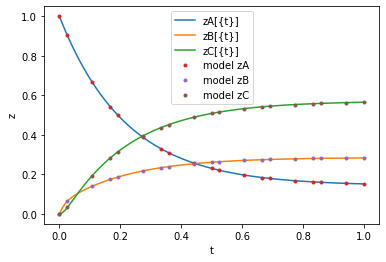

In [6]:
# Create Pyomo model
model = create_model()

# Initialize discretized model with simulation result?
init = True

# Number of finite elements
NFE = 6

# Simulate model
sim, tsim, profiles = simulate_discretize_model(model,NFE,init)

# Plot simulation results
plot_result(model, sim, tsim, profiles,True)

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      462
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      113
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total 

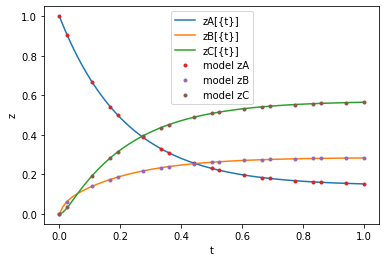

In [7]:
# Solve collocation formulation with Ipopt
solve_model(model)

# Plot results
plot_result(model, sim, tsim, profiles, True)

### 2.10.1.7 Simulate and solve Pyomo model without initialization

Repeat the analysis from above, but do NOT initialize the discretized model with the simulation result. (Tip: you only need to change two small things.)

FORWARD INTEGRATION:
Number of steps taken by SUNDIALS: 133
Number of calls to the user’s f function: 161
Number of calls made to the linear solver setup function: 25
Number of error test failures: 0
Method order used on the last internal step: 5
Method order to be used on the next internal step: 5
Actual value of initial step size: 2.16496e-09
Step size taken on the last internal step: 0.00594889
Step size to be attempted on the next internal step: 0.0118978
Current internal time reached: 0.0118978
Number of nonlinear iterations performed: 159
Number of nonlinear convergence failures: 0



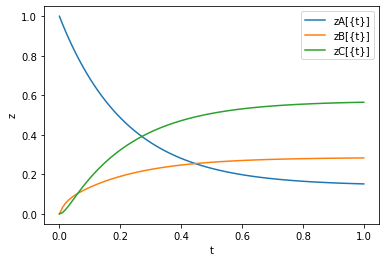

Ipopt 3.13.3: 

******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit https://github.com/coin-or/Ipopt
******************************************************************************

This is Ipopt version 3.13.3, running with linear solver mumps.
NOTE: Other linear solvers might be more efficient (see Ipopt documentation).

Number of nonzeros in equality constraint Jacobian...:      462
Number of nonzeros in inequality constraint Jacobian.:        0
Number of nonzeros in Lagrangian Hessian.............:        0

Total number of variables............................:      113
                     variables with only lower bounds:        0
                variables with lower and upper bounds:        0
                     variables with only upper bounds:        0
Total 

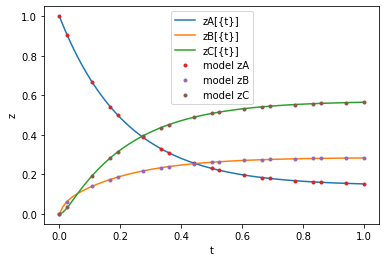

In [8]:
# YOUR SOLUTION HERE
# Create Pyomo model
model = create_model()

# Initialize discretized model with simulation result?
init = False


# Simulate model
sim, tsim, profiles = simulate_discretize_model(model,NFE,init)

# Plot simulation results
plot_result(model, sim, tsim, profiles,False)

# Solve collocation formulation with Ipopt
solve_model(model)

# Plot results
plot_result(model, sim, tsim, profiles, True)

### 2.10.1.8 Discussion: Does initialization matter?

Write 1 to 3 sentences for each of the following questions:

*What happens if we disable initialization? Does the number of interactions Ipopt need change?*

Not much happens.  Ipopt needs the same number of iterations either way.



*Why is this specific problem robust to poor initialization? What about this specific DAE system makes it easy to solve?*

This specific problem is robust to poor initialization due to it consisting of first order linear ordinary differential equations.

### 2.10.1.9 Degree of Freedom Analysis

Please answer on paper and turn in via Gradescope.

Rerun the code above for two different numbers of finite elements. Record the total number of variables and equality constraints.

How many degrees of freedom are in the simulation problem? (1 sentence is fine.)

Choose $N=3$ or a simular number of finite elements. Using the collocation equations from class, show that the discretized Pyomo model has the correct number of variables and algebriac equations. This will be a little tedious, but good to practice once on a simple model. You might need to do this when debugging a DAE model for research.

<!--NAVIGATION-->
< [2.9 Pyomo Homework 2](https://ndcbe.github.io/CBE60499/02.09-Pyomo2.html) | [Contents](toc.html) | [3.0 Unconstrained Nonlinear Optimization: Theory and Algorithms](https://ndcbe.github.io/CBE60499/03.00-Unconstrained.html) ><p><a href="https://colab.research.google.com/github/ndcbe/CBE60499/blob/master/docs/02.10-Pyomo3.ipynb"> <img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open in Google Colaboratory"></a><p><a href="https://ndcbe.github.io/CBE60499/02.10-Pyomo3.ipynb"> <img align="left" src="https://img.shields.io/badge/Github-Download-blue.svg" alt="Download" title="Download Notebook"></a>